# Task 13 - Knee angle

Implement the knee angle changes for isometric contraction, using the model of Nigg and Herzog (2003)

## Simulation - Series

In [1]:
def TendonForce (Lnorm_see,Lslack, Lce_o):
    '''
    Compute tendon force

    Inputs:
        Lnorm_see = normalized tendon length
        Lslack = slack length of the tendon (non-normalized)
        Lce_o = optimal length of the fiber
    
    Output:
        Fnorm_tendon = normalized tendon force
        
    '''
    Umax = .04
    
    if Lnorm_see<Lslack/Lce_o: 
        Fnorm_tendon = 0
    else: 
        Fnorm_tendon = ((Lnorm_see-Lslack/Lce_o)/(Umax*Lslack/Lce_o))**2
        
    return Fnorm_tendon

In [2]:
def ParallelElementForce (Lnorm_ce):
    '''
    Compute parallel element force
    
    Inputs:
        Lnorm_ce = normalized contractile element length
    
    Output:
        Fnorm_kpe = normalized parallel element force

    '''
    Umax = 1
    
    if Lnorm_ce< 1: 
        Fnorm_kpe = 0
    else: 
        Fnorm_kpe = ((Lnorm_ce-1)/(Umax*1))**2 
        
    return Fnorm_kpe

In [3]:
def ForceLengthCurve (Lnorm_ce,width):
    F0 = max([0, (1-((Lnorm_ce-1)/width)**2)])
    return F0

In [4]:
def ContractileElementDot(F0, Fnorm_CE, a):
    
    '''
    Compute Contractile Element Derivative

    Inputs:
        F0 = Force-Length Curve
        Fce = Contractile element force
    
    Output:
        Lnorm_cedot = normalized contractile element length derivative

    '''
    
    FMlen = 1.4 # young adults
    Vmax = 10  # young adults
    Af = 0.25  #force-velocity shape factor
    
    Fnorm_CE = min(FMlen*a*F0 - 0.001, Fnorm_CE)
    
    if  Fnorm_CE > a*F0:
        
        b = ((2 + 2/Af)*(a*F0*FMlen - Fnorm_CE))/(FMlen-1)
        
    elif Fnorm_CE <= a*F0:
        
        b = a*F0 + Fnorm_CE/Af
    
    Lnorm_cedot = (.25 + .75*a)*Vmax*((Fnorm_CE - a*F0)/b)
    
    return Lnorm_cedot

In [5]:
def ContractileElementForce(Fnorm_tendon,Fnorm_kpe, alpha):
    '''
    Compute Contractile Element force

    Inputs:
        Fnorm_tendon = normalized tendon force
        Fnorm_kpe = normalized parallel element force
    
    Output:
        Fnorm_CE = normalized contractile element force
    '''
    Fnorm_CE = Fnorm_tendon/np.cos(alpha) - Fnorm_kpe
    return Fnorm_CE

In [6]:
def tendonLength(Lm,Lce_o,Lnorm_ce, alpha):
    '''
    Compute tendon length
    
    Inputs:
        Lm = 
        Lce_o = optimal length of the fiber
        Lnorm_ce = normalized contractile element length
    
    Output:
        Lnorm_see = normalized tendon length   
    '''
    Lnorm_see = Lm/Lce_o - Lnorm_ce*np.cos(alpha)
    
    return Lnorm_see

In [7]:
def activation(a,u,dt):
    '''
    Compute activation
    
    Inputs:
        u = idealized muscle excitation signal, 0 <= u <= 1
        a = muscular activation
        dt = time step
    
    Output:
        a = muscular activation  
    '''
    
    tau_deact = 50e-3 #young adults
    tau_act = 15e-3
    
    if u>a:
        tau_a = tau_act*(0.5+1.5*a)
    elif u <=a:
        tau_a = tau_deact/(0.5+1.5*a)
    
    #-------
    dadt = (u-a)/tau_a # euler
    
    a += dadt*dt
    #-------
    return a

In [8]:
def TotalMomentKneeJoint(Rf, Fnorm_tendon, m, g, Rcm, phi):
    M = Rf * Fnorm_tendon - m*g * Rcm * np.sin(phi - np.pi/2)
    return M

## Simulation - Parallel

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import math


%matplotlib inline

In [10]:
# Muscle properties
Lslack = .223
Umax = .04
Lce_o = .093 #optmal l
width = .63#*Lce_o
Fmax = 7400
a = 0
u = 0.5
#b = .25*10#*Lce_o 

# Parameters for the equation of motion
m = 10; g = 9.81;
Rcm = 0.264;
I = 0.1832;
Rf = 0.033;

# Initial conditions
Lnorm_ce = .087/Lce_o #norm
t0 = 0
tf = 5
h = 1e-3;
phi = np.pi/2; phid = 0.0;

# Initialization
t = np.arange(t0,tf,h)
F = np.empty(t.shape)
Fkpe = np.empty(t.shape)
FiberLen = np.empty(t.shape)
TendonLen = np.empty(t.shape)
a_dynamics = np.empty(t.shape)
Phi = np.empty(t.shape)

In [11]:
phi = np.pi/2; phid = 0.0;

#Normalizing
alpha = 0*np.pi/180


for i in range (len(t)):
    #ramp
    if t[i]<=1:
        Lm = 0.31
    elif t[i]>1 and t[i]<2:
        Lm = .31 - .04*(t[i]-1)
        #print(Lm)
    
    #shortening at 4cm/s
    u = 0.7 + 0.2*np.sin(np.pi*t[i])
    
    Lnorm_see = tendonLength(Lm,Lce_o,Lnorm_ce, alpha)

    Fnorm_tendon = TendonForce (Lnorm_see,Lslack, Lce_o) 
    
    Fnorm_kpe = ParallelElementForce (Lnorm_ce)     
        
    #isometric force at Lce from CE force length relationship
    F0 = ForceLengthCurve (Lnorm_ce,width)
    
    Fnorm_CE = ContractileElementForce(Fnorm_tendon,Fnorm_kpe, alpha) #Fnorm_CE = ~Fm
    
    
    
    #computing activation
    a = activation(a,u,h)
    
    #calculate CE velocity from Hill's equation    
    Lnorm_cedot = ContractileElementDot(F0, Fnorm_CE,a)
    
    M = TotalMomentKneeJoint(Rf, Fnorm_tendon, m, g, Rcm, phi) # total moment with respect to knee joint
    phidd = M/I; # angular acceleration
    
    # --- Euler integration step
    Lnorm_ce += h*Lnorm_cedot
    
    phid = phid + phidd * h
    
    phi = phi + phid * h
    
    

    
    F[i] = Fnorm_tendon*Fmax
    Fkpe[i] = Fnorm_kpe*Fmax
    FiberLen[i] = Lnorm_ce*Lce_o
    TendonLen[i] = Lnorm_see*Lce_o
    a_dynamics[i] = a
    
    Phi[i] = phi
    

## Plots 

Text(0,0.5,'Knee Angle [degrees]')

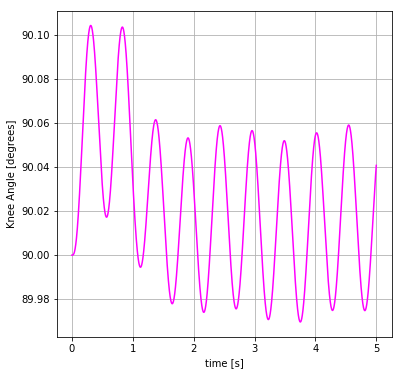

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(6,6), sharex=True)

ax.plot(t,Phi*180/np.pi,c='magenta')
plt.grid()
plt.xlabel('time [s]')
plt.ylabel('Knee Angle [degrees]')



Text(0,0.5,'Force (N)')

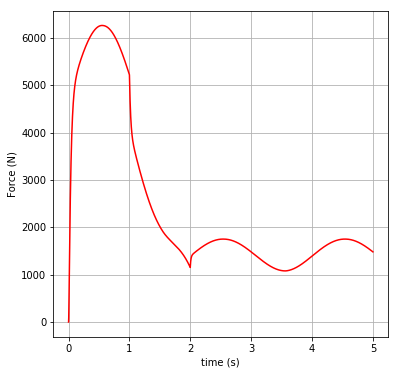

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(6,6), sharex=True)

ax.plot(t,F,c='red')
plt.grid()
plt.xlabel('time (s)')
plt.ylabel('Force (N)')

Text(0,0.5,'Length (m)')

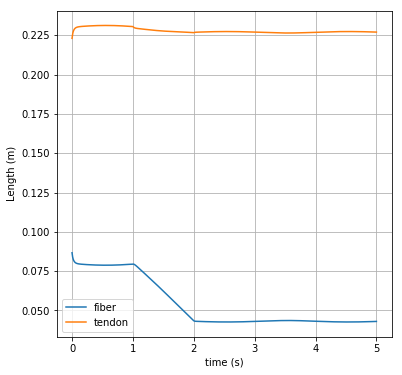

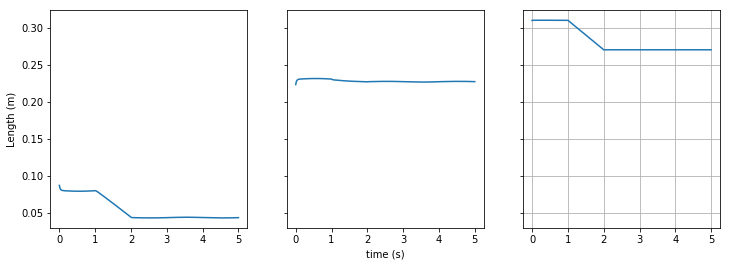

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(6,6), sharex=True)

ax.plot(t,FiberLen, label = 'fiber')
ax.plot(t,TendonLen, label = 'tendon')
plt.grid()
plt.xlabel('time (s)')
plt.ylabel('Length (m)')
ax.legend(loc='best')


fig, ax = plt.subplots(1, 3, figsize=(12,4), sharex=True, sharey=True)
ax[0].plot(t,FiberLen, label = 'fiber')
plt.grid()
ax[1].plot(t,TendonLen, label = 'tendon')
plt.grid()
ax[2].plot(t,FiberLen + TendonLen, label = 'muscle (tendon + fiber)')
plt.grid()

ax[1].set_xlabel('time (s)')
ax[0].set_ylabel('Length (m)')
